## 1.0 Pre-Processing: Converting Audio Files to Mel Spectrograms

Audio data and metadata obtained from: https://github.com/mdeff/fma

### Table of Contents
[1.1. Setup](#1.)<br>
[1.1.1 Loading libraries](#1.1)<br>
[1.1.2 Defining functions](#1.2)<br>
[1.1.3 Setting data directories](#1.3)<br>

[1.2. Spectrograms](#2.)<br>
[1.2.1 Sample print of spectrograms](#2.1)<br>
[1.2.2 Generation of full length spectrograms](#2.2)<br>

[1.3. Sub-sampling of Spectrograms](#3.)<br>
[1.3.1 Sub-sample of shorter spectrograms](#3.1)<br>
[1.3.2 Setting parameters for randomized sub-sampling](#3.2)<br>
[1.3.3 Generation of multiple shorter length spectrograms](#3.3)<br>

[1.4. Generation of Numpy Arrays](#4.)<br>
[1.4.1 Splitting into train, validation, and test sets](#4.1)<br>
[1.4.2 Setting parameters for randomized sub-sampling](#4.2)<br>
[1.4.3 Generation of spectrograms and saving as .npy files](#4.3)<br>
[1.4.4 Generation of spectrograms with random seeds and saving as .npy files](#4.4)<br>

[1.5. Generation of Single Sample Set for Embeddings](#5.)<br>
[1.5.1 Generation of full set of 10s .npy files for embedding set](#5.1)<br> 


### 1.1. Setup <a class="anchor" id="1."></a>

#### 1.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
import datetime

#### 1.1.2 Defining functions <a class="anchor" id="1.2"></a>

In [2]:
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    audio_dir = './data/fma_small'
    >>> get_audio_path(audio_dir, 2)
    Returns
    -------    
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return f'{audio_dir}/{tid_str[:3]}/{tid_str}.mp3'


def get_tids_from_directory(audio_dir, exclude_dir, exclude_file):
    """
    Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    exclude_dir : list of str
        Directory names within the audio_dir that are to be excluded.
    exclude_file : list of str
        File names within the audio_dir that are to be excluded.
    Returns
    -------
        A list of track IDs.
    """
   
    tids = []
        
    for _, dirnames, files in os.walk(audio_dir):
        # Exclude all files in the directories listed in exclude_dir
        dirnames[:] = [d for d in dirnames if d not in exclude_dir]
        # Exclude the files listed in exclude_files
        files[:] = [f for f in files if f not in exclude_file]
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids


def get_error_tids(audio_dir, tids):
    '''
    Get a list of errorneous audio files in the audio directory
    which are listed in the tids but cannot be read by librosa
    Returns
    -------
        A list of errorneous track IDs.
    '''
    error_log = []
    for tid_name in tids:
        filepath = get_audio_path(audio_dir, tid_name)

        try:
            librosa.load(filepath)
        except:
            print("Error loading file: {}".format(filepath))
            error_log.append(tid_name)
    
    return error_log


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath, exist_ok=True)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [3]:
def generate_spect_db(filepath):
    '''
    Takes input of a filepath for a single audio file from the FMA data
    Returns the mel spectrogram in dB scale 
    '''
    # Obtain the waveform "y" in time-axis and the sample rate "sr"
    # by default, all audio is mixed to mono and resampled to 22,050 Hz at load time;
    # for a 30s audio sample, y would be a 1D array of ~661,500 length
    y, sr = librosa.load(filepath)

    # Trim time-series to exactly 655,081 (29.70889s) since some variation exists,
    # this results in a spectrogram shape of [ , 1280]
    y = y[:655081]
    
    # Generate mel spectorgrams and convert dB scale
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
    spect_db = librosa.power_to_db(S=spect, ref=np.max)
    
    return spect_db


def plot_spect_db(spect_db, colorbar=True, axes=True):
    '''
    Takes a mel spectrogram in dB scale as input 
    Returns the plot of a mel spectrogram 
    '''
    # Plot spectorgram
    librosa.display.specshow(spect_db, y_axis='mel', fmax=8000, x_axis='time')
    if colorbar==True:
        plt.colorbar(format='%+2.0f dB')
    if axes==False:
        plt.axis('off')

In [4]:
# Setting up function for generating and exporting all spectrograms as .png files

def export_all_spect_db(audio_dir, tids):
    '''
    Takes input of a directory for all the audio files from the FMA data
    Saves a .png print of the spectrograms in the directory under ./spect_db/
    '''
    # Set the saving directory path for the spectrograms
    savepath = f'./data/spect_full'
    # Creates the directory
    mkdir_p(savepath)
    
    for tid_name in tids:
        # Close all figures before starting
        plt.close('all')
        
        # Get the full path of the audio file
        filepath = get_audio_path(audio_dir, tid_name)
        # Generate the mel spectrogram in dB scale
        spect_db = generate_spect_db(filepath)
          
        # Plot the spectrogram, without colorbars, axes or titles
        plt.figure(figsize=(10, 4))
        plot_spect_db(spect_db, colorbar=False, axes=False)
        
        # Save the figure
        tid_str = '{:06d}'.format(tid_name)
        plt.savefig(f'{savepath}/{tid_str}_spect_db.png')
        
        plt.clf

In [5]:
# Setting up functions for generating and exporting subsample spectrograms and saving as .png files

def generate_subsample_spect_db(filepath, s_sec=10, s_qty=5, seed_num=None):
    '''
    Takes input of a filepath for a single audio file from the FMA data
    Randomly takes s_qty (default 5) samples of s_sec (default 10s) from the ~30s clip 
    Returns the set of samples of the mel spectrogram in dB scale 
    '''
    #Set random seed number
    random.seed(seed_num)
    
    # Obtain the waveform "y" in time-axis and the sample rate "sr"
    # by default, all audio is mixed to mono and resampled to 22,050 Hz at load time;
    # for a 30s audio sample, y would be a 1D array of ~661,500 length
    y, sr = librosa.load(filepath)

    # Trim time-series to exactly 655,081 (29.70889s) since some variation exists,
    # this results in a spectrogram shape of [ , 1280]
    y = y[:655081]
    
    # Calculate the sub-sample time-series length
    s_y_len = sr * s_sec

    # Setup an empty list for the sub-samples
    s_spect_db = []
    
    for i in range(s_qty):
        # Sub-sample the time-series
        s_y_start = random.randint(0,655081-s_y_len)
        s_y_end = s_y_start + s_y_len
        s_y = y[s_y_start:s_y_end]

        # Generate sun-sample mel spectorgrams and convert dB scale
        s_spect = librosa.feature.melspectrogram(y=s_y, sr=sr, n_fft=2048, hop_length=512)
        s_spect_db.append(librosa.power_to_db(S=s_spect, ref=np.max))
    
    return s_spect_db


def export_all_subsample_spect_db(audio_dir, tids, s_sec=10, s_qty=5, seed_num=None):
    '''
    Takes input of a directory for all the audio files from the FMA data
    Passes s_qty (default 5) samples of s_sec (default 10s) and 
    passes them into function generate_subsample_spect_db.
    Saves a print of the spectrograms in the directory under ./spect_db/
    '''
    # Set the saving directory path for the spectrograms
    savepath = f'./data/spect_subsample_{s_sec}s'
    # Creates the directory
    mkdir_p(savepath)
    
    for tid_name in tids:
        # Close all figures before starting
        plt.close('all')
        
        # Get the full path of the audio file
        filepath = get_audio_path(audio_dir, tid_name)
        # Generate the mel spectrogram in dB scale
        # Note: this version generates a number of sub-samples
        s_spect_db = generate_subsample_spect_db(filepath, s_sec, s_qty, seed_num)
        
        for i,sample in zip(range(1,s_qty+1),s_spect_db):
            
            # Plot the spectrogram, without colorbars, axes or titles
            plt.figure(figsize=(4, 4))
            plot_spect_db(sample, colorbar=False, axes=False)

            # Save the figure
            tid_str = '{:06d}-{}'.format(tid_name, i)
            plt.savefig(f'{savepath}/{tid_str}_spect_db_{s_sec}s.png')
            
            plt.clf

In [6]:
# Setting up function for generating spectrograms and exporting to numpy array .npy
# shape of output: (no.samples, spectrogram time-series, spectrogram frequency)

def export_spect_as_npy(audio_dir, data_name, tids):
    '''
    Takes input of a directory for all the audio files from the FMA data
    Saves a the spectrograms to a numpy array in the directory under 
    ./spect_full_np/{data_name}
    data_name: e.g. 'train', 'val', or 'test' 
    
    Returns
    -------
    spectrogram in numpy array,
        shape: (no.samples, spectrogram time-series, spectrogram frequency)
    '''
    # Set the saving directory path for the spectrograms
    savepath = f'./data/spect_full_np'
    # Creates the directory
    mkdir_p(savepath)
    
    spect_np = np.empty((0, 1280, 128))
    
    # Start timer
    start_time = timeit.default_timer()
    counter = 0
    print("\nProcessing '{}' set audio data to spectrograms and writing output to .npy".format(data_name))
    
    for tid_name in tids:
        
        #Sets the counter running, refreshing elaspsed time and new line every 100 examples
        counter += 1
        elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
        print("Processing sample no: {}, time elasped (h:mm:ss): {} ".format(counter, elapsed[:-7]), end='\r') 
        if counter % 100 == 0:
            print("", end='\n')
                
        # Get the full path of the audio file
        filepath = get_audio_path(audio_dir, tid_name)
        # Generate the mel spectrogram in dB scale
        spect_db = generate_spect_db(filepath)
        spect_dbT = spect_db.T
        
        spect_np = np.append(spect_np, [spect_dbT], axis=0)
          
    np.save(f'{savepath}/{data_name}_spect', spect_np)
        
    # End timer
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("Array saved as: {}.npy".format(f'{savepath}/{data_name}_spect'))
        
    return spect_np

In [7]:
# Setting up function for generating spectorgrams and exporting to numpy array .npy
# shape of output: (no.samples, spectrogram time-series, spectrogram frequency)

def export_subsample_spect_as_npy(audio_dir, data_name, tids, s_sec=10, s_qty=5, seed_num=None):
    '''
    Takes input of a directory for all the audio files from the FMA data
    Passes s_qty (default 5) samples of s_sec (default 10s) and 
    passes them into function generate_subsample_spect_db.
    Saves a the spectrograms to a numpy array in the directory under 
        ./data/spect_subsample_{s_qty}x{s_sec}s_np
    with filename
        {data_name}_spect_{s_qty}x{s_sec}s_seed{seed_num}_np.npy 
    if seed_num != None or
        {data_name}_spect_{s_qty}x{s_sec}s_np.npy
    if seed_num == None
    data_name: e.g. 'train', 'val', or 'test' 
    
    Returns
    -------
    spectrogram in numpy array, 
        shape: (no.of sub-samples, spectrogram time-series, spectrogram frequency)    
    '''
    # Set the saving directory path for the spectrograms
    savepath = f'./data/spect_subsample_{s_qty}x{s_sec}s_np'
    # Creates the directory
    mkdir_p(savepath)
       
    s_spect_np = np.empty((0, s_qty, 431, 128))
    
    # Start timer
    start_time = timeit.default_timer()
    counter = 0
    print("\nProcessing '{}' set audio data to spectrograms and writing output to .npy".format(data_name))
    print("Sub-sampling each recording with {} samples of {}s each.".format(s_qty, s_sec))
    
    for tid_name in tids:
        
        #Sets the counter running, refreshing elaspsed time and new line every 200 examples
        counter += 1
        elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
        print("Processing sample no: {}, time elasped (h:mm:ss): {} ".format(counter, elapsed[:-7]), end='\r') 
        if counter % 200 == 0:
            print("", end='\n')
                
        # Get the full path of the audio file
        filepath = get_audio_path(audio_dir, tid_name)
        # Generate the mel spectrogram in dB scale
        # Note: this version generates a number of sub-samples
        s_spect_db = generate_subsample_spect_db(filepath, s_sec, s_qty, seed_num)
        s_spect_dbT = np.array(s_spect_db).transpose((0,2,1))
        
        s_spect_np = np.append(s_spect_np, [s_spect_dbT], axis=0)
          
    # Reshaping the 4D array to 3D
    s_spect_np = np.reshape(s_spect_np, (s_spect_np.shape[0] * s_spect_np.shape[1], 431, 128))
    
    if seed_num != None:
        np.save(f'{savepath}/{data_name}_spect_{s_qty}x{s_sec}s_seed{seed_num}_np', s_spect_np)
    else:
        np.save(f'{savepath}/{data_name}_spect_{s_qty}x{s_sec}s_np', s_spect_np)    
                       
    # End timer
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("Array saved as: {}.npy".format(f'{savepath}/{data_name}_spect_{s_qty}x{s_sec}s_seed{seed_num}_np'))
        
    return s_spect_np


def export_subsample_labels_as_npy(data_name, labels, s_sec=10, s_qty=5):
    '''
    Function that takes a set of data labels and extends it by the number of 
    sub-samples per audio file, s_qty.
    Saves the labels to a numpy array in the directory 
        ./data/spect_subsample_{s_qty}x{s_sec}s_np
    with filename:
        {data_name}_labels_{s_qty}x{s_sec}s_np.npy
    data_name: e.g. 'train', 'val', or 'test' 

    Returns
    -------
    labels in numpy array, 
        shape: (no.samples, no.of sub-samples)    
    '''
    # Set the saving directory path for the spectrograms
    savepath = f'./data/spect_subsample_{s_qty}x{s_sec}s_np'
    # Creates the directory
    mkdir_p(savepath)
    
    #Define an empty 1D numpy array
    s_labels = np.empty(0)
    
    print("\nProcessing '{}' set labels.".format(data_name))
    for i in range(len(labels)):
        s_labels = np.append(s_labels, [labels[i]] * s_qty, axis=None)
    
    np.save(f'{savepath}/{data_name}_labels_{s_qty}x{s_sec}s_np', s_labels)
    print("Array saved as: {}.npy".format(f'{savepath}/{data_name}_labels_{s_qty}x{s_sec}s_np'))
        
    return s_labels


#### 1.1.3 Setting data directories <a class="anchor" id="1.3"></a>

In [8]:
data_set_choices = ['small', 'medium', 'large']
data_set = data_set_choices[0]

# Exclusions
# Adding a list of excluded directories for the walk
exclude_dir = []
# Adding a list of excluded audio files due to errors
exclude_file = ['099134.mp3', '108925.mp3', '133297.mp3',
                '098565.mp3', '098567.mp3', '098569.mp3']

# Setting the directory for the mp3 audio samples
audio_dir = f'./data/fma_{data_set}'

# Extracting the Track IDs from the entire directory
tids = get_tids_from_directory(audio_dir, exclude_dir, exclude_file)
print("No. of tracks in '{}' is {}".format(audio_dir,len(tids)))

# For troubleshooting, exporting the tids to a csv file for reference
tids_df = pd.DataFrame(tids)
tids_df.to_csv("./tids.csv", sep=',',index=False, header=False)

No. of tracks in './data/fma_small' is 7994


In [9]:
# # Note: This code need not be re-run if errorneous files have been removed.

# # Find and remove errorneous audio files
# error_log = get_error_tids(audio_dir, tids)
# print("\nNo. of errorneous files: {}".format(len(error_log)))
# print("List of errorneous track ids: {}".format(error_log))

# for i in error_log:
#     tids.remove(i)

# print("\nNo. of non-errorneous tracks in '{}' is {}".format(audio_dir,len(tids)))

# # The following track ids were found to be errorneous and added to the exclude_file list.
# # Error loading file: ./data/fma_small/099/099134.mp3
# # Error loading file: ./data/fma_small/108/108925.mp3
# # Error loading file: ./data/fma_small/133/133297.mp3

# # Another set of tracks were found to be much shorter than 30s during sub-sampling.
# # 15s long: ./data/fma_small/098/098565.mp3
# # 03s long: ./data/fma_small/098/098567.mp3
# # 05s long: ./data/fma_small/098/098569.mp3

In [9]:
# Setting the path for the tracks.csv 
tracks_csv_path = './data/fma_metadata/tracks.csv'
tracks_raw = pd.read_csv(tracks_csv_path , index_col=0, header=[0, 1])

# Removing the errorneous files listed in exclude_file
for i in exclude_file:
    tracks_raw = tracks_raw.drop((int(i.split('.')[0])))

tracks_raw.head(2)

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   

                                                             ...       \
         favorites id information listens producer tags      ...        
track_id                                                     ...        
2                4  1     <p></p>    6073      NaN   []      ...        
3                4  1     <p></p>    6073      NaN   []      ...        

               track                         \
         information interest language_code   
track_id                                      
2                NaN     4656            en   
3                NaN     1470            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   

                                              
         number publisher tags         title  
track_id                                      
2             3       NaN   []          Food  
3             4       NaN   []  Electric Ave  

[2 rows x 52 columns]

In [10]:
print(list(tracks_raw))

[('album', 'comments'), ('album', 'date_created'), ('album', 'date_released'), ('album', 'engineer'), ('album', 'favorites'), ('album', 'id'), ('album', 'information'), ('album', 'listens'), ('album', 'producer'), ('album', 'tags'), ('album', 'title'), ('album', 'tracks'), ('album', 'type'), ('artist', 'active_year_begin'), ('artist', 'active_year_end'), ('artist', 'associated_labels'), ('artist', 'bio'), ('artist', 'comments'), ('artist', 'date_created'), ('artist', 'favorites'), ('artist', 'id'), ('artist', 'latitude'), ('artist', 'location'), ('artist', 'longitude'), ('artist', 'members'), ('artist', 'name'), ('artist', 'related_projects'), ('artist', 'tags'), ('artist', 'website'), ('artist', 'wikipedia_page'), ('set', 'split'), ('set', 'subset'), ('track', 'bit_rate'), ('track', 'comments'), ('track', 'composer'), ('track', 'date_created'), ('track', 'date_recorded'), ('track', 'duration'), ('track', 'favorites'), ('track', 'genre_top'), ('track', 'genres'), ('track', 'genres_all'

In [11]:
tracks = tracks_raw[tracks_raw[('set', 'subset')] == data_set]
keep_cols = [('set', 'split'),
             ('artist', 'id'), ('artist', 'name'), ('artist', 'favorites'),
             ('track', 'title'), ('track', 'date_created'),
             ('track', 'genre_top'), ('track', 'genres'), 
             ('track', 'favorites'), ('track', 'interest'), ('track', 'listens')]
tracks = tracks[keep_cols]
tracks.head()

set artist                                             \
             split     id                             name favorites   
track_id                                                               
2         training      1                             AWOL         9   
5         training      1                             AWOL         9   
10        training      6                        Kurt Vile        74   
140       training     54  Alec K. Redfearn & the Eyesores        11   
141       training     54  Alec K. Redfearn & the Eyesores        11   

                       track                                                  \
                       title         date_created genre_top genres favorites   
track_id                                                                       
2                       Food  2008-11-26 01:48:12   Hip-Hop   [21]         2   
5                 This World  2008-11-26 01:48:20   Hip-Hop   [21]         6   
10                   Freeway  2008-11-25 17:49:06       Pop   [10]       178   
140       Queen Of The Wires  2008-11-26 01:44:07      Folk   [17]         5   
141                     Ohio  2008-11-26 01:44:10      Folk   [17]         1   

                           
         interest listens  
track_id                   
2            4656    1293  
5            1933    1151  
10          54881   50135  
140          1593    1299  
141           839     725

In [12]:
tracks.describe()

artist                     track                             
                 id    favorites    favorites      interest        listens
count   7994.000000  7994.000000  7994.000000  7.994000e+03    7994.000000
mean   12980.890418    41.676507     6.570053  7.197485e+03    4731.083938
std     6995.718200   111.408660    23.858777  4.623860e+04   12226.353279
min        1.000000     0.000000     0.000000  4.630000e+02     196.000000
25%     7291.250000     2.000000     1.000000  1.880000e+03    1267.000000
50%    13830.000000     8.000000     3.000000  3.490500e+03    2493.000000
75%    19459.000000    25.000000     7.000000  6.812750e+03    4898.500000
max    24252.000000   963.000000  1482.000000  3.293557e+06  543252.000000

In [13]:
genre_list = list(tracks[('track','genre_top')].unique())
genre_list

['Hip-Hop',
 'Pop',
 'Folk',
 'Experimental',
 'Rock',
 'International',
 'Electronic',
 'Instrumental']

In [14]:
# Exporting tracks to csv for use in other notebooks
tracks.to_csv("./tracks.csv", sep=',',index=True, header=True)

### 1.2. Spectrograms <a class="anchor" id="2."></a>

Utilizing librosa library: https://librosa.github.io/librosa/tutorial.html

#### 1.2.1 Sample print of spectrograms <a class="anchor" id="2.1"></a>

Sample file: ./data/fma_small/141/141167.mp3
(Time series 'y', Sample rate 'sr'): (660984,22050)
Cropped Time series 'y': 655081
Spectrogram shape: (128, 1280)


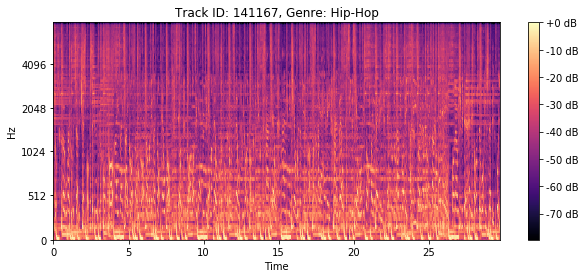

In [11]:
# Select a genre 0-7 
#0 : 'Hip-Hop',
#1 : 'Pop',
#2 : 'Folk',
#3 : 'Experimental',
#4 : 'Rock',
#5 : 'International',
#6 : 'Electronic',
#7 : 'Instrumental'
genre = genre_list[0]

# Get random track id of the chosen genre 
tid_name = random.choice(list(tracks[tracks[('track','genre_top')] == genre].index))

# Get the path of the selected audio file
filepath = get_audio_path(audio_dir, tid_name)
print("Sample file: {}".format(filepath))

# Obtain the waveform "y" in time-axis and the sample rate "sr"
# by default, all audio is mixed to mono and resampled to 22,050 Hz at load time;
# for a 30s audio sample, y would be a 1D array of ~661,500 length
y, sr = librosa.load(filepath)
print("(Time series 'y', Sample rate 'sr'): ({},{})".format(len(y),sr))

# Trim time-series to exactly 655,081 (29.70889s) since some variation exists,
# this results in a spectrogram shape of [ , 1280]
y = y[:655081]
print("Cropped Time series 'y': {}".format(len(y)))

# Generate mel spectorgrams and convert dB scale
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
spect_db = librosa.power_to_db(S=spect, ref=np.max)
print("Spectrogram shape: {}".format(spect_db.shape))

# Plot spectorgram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect_db, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Track ID: {tid_name}, Genre: {genre}')
plt.show()

Functions `generate_spect_db` and `plot_spect_db` were added to [1.1.2](#1.2) to allow more modular code for the generation and plotting of spectrograms.

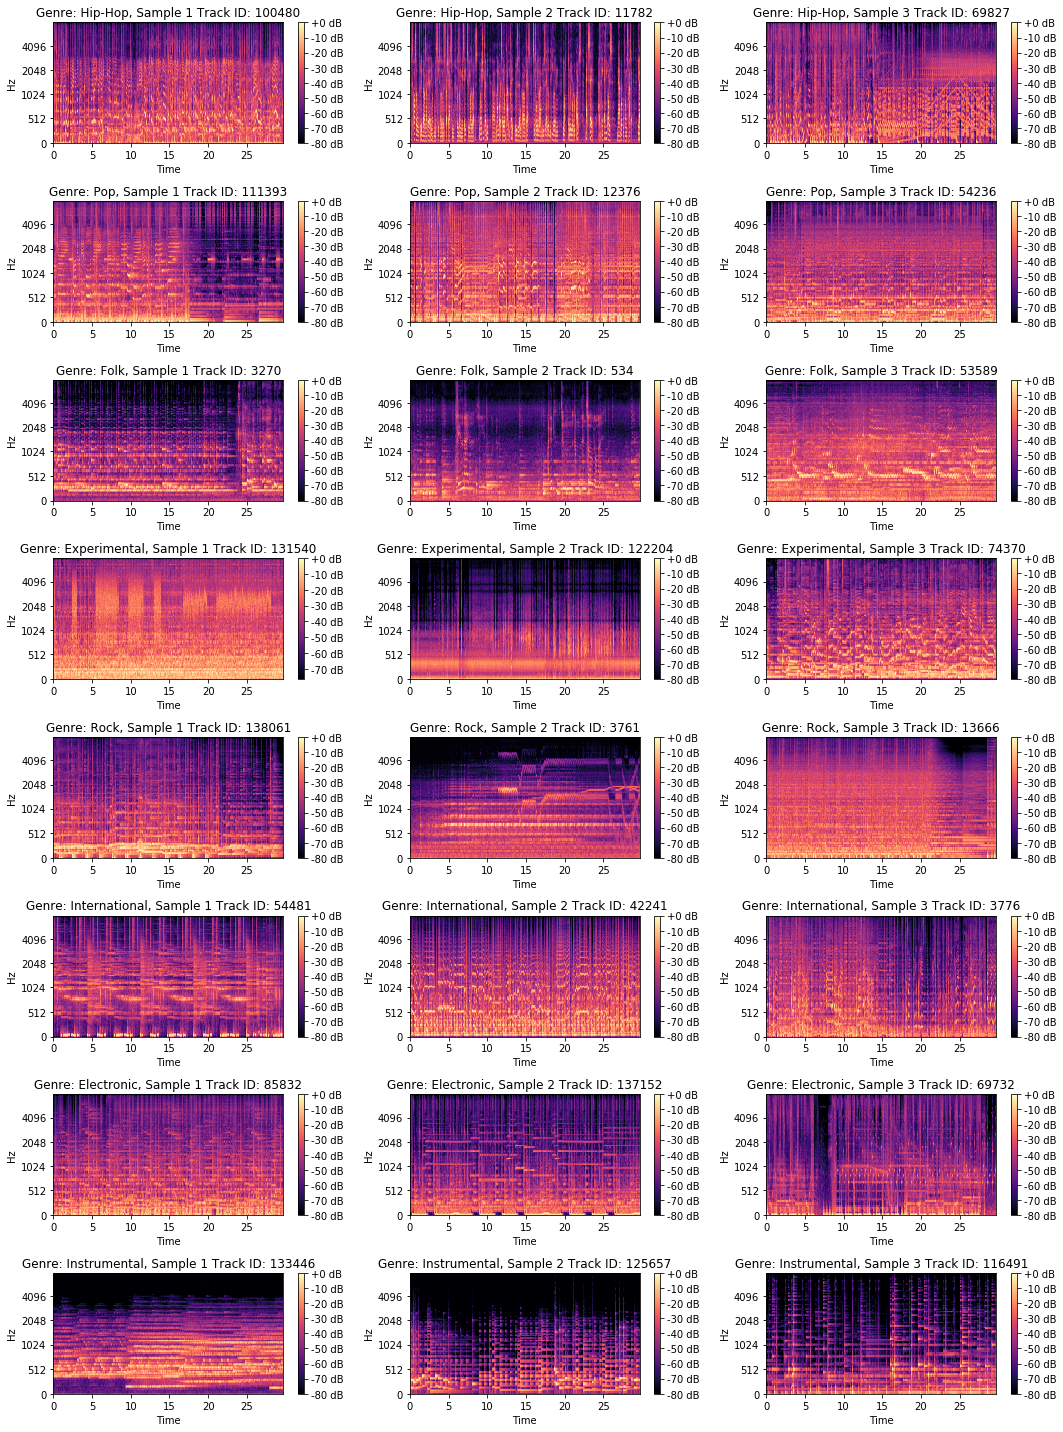

In [16]:
# Running a loop to display a random sample of each genre's spectorgrams
num_samples = 3

# Setup the figure subplots
fig, ax = plt.subplots(len(genre_list), num_samples, figsize=(15,20))

# Define empty nested lists
tid_name = [[None for j in range(num_samples)] for i in range(len(genre_list))]
filepath = [[None for j in range(num_samples)] for i in range(len(genre_list))]
spect_db = [[None for j in range(num_samples)] for i in range(len(genre_list))]  

# Loop to populate the nested lists
for i in range(0, len(genre_list)):    
    for j in range(0, num_samples):
        # Get random track id of the chosen genre
        tid_name[i][j] = random.choice(list(tracks[tracks[('track','genre_top')] == genre_list[i]].index))
        # Get the path of the selected audio file
        filepath[i][j] = get_audio_path(audio_dir, tid_name[i][j])
        # Generate the spectrogram
        spect_db[i][j] = generate_spect_db(filepath[i][j])
        
# Loop to plot the spectrograms
for i in range(0, len(genre_list)):
    for j in range(0, num_samples):
        ax[i,j] = plt.subplot(len(genre_list), num_samples, (i*num_samples)+j+1)
        plot_spect_db(spect_db[i][j], colorbar=True)
        plt.title(f'Genre: {genre_list[i]}, Sample {j+1} Track ID: {tid_name[i][j]}')
plt.tight_layout()

#### 1.2.2 Generation of full length spectrograms <a class="anchor" id="2.2"></a>

Function `export_all_spect_db` was added to [1.1.2](#1.2) and used to generate a set of full length spectrograms and save them as `.png` files.

In [ ]:
# # Note: This takes a long time to run for the extraction ~ 2hr 45min
# export_all_spect_db(audio_dir, tids)

### 1.3. Sub-sampling of Spectrograms <a class="anchor" id="3."></a>

#### 1.3.1 Sub-sample of shorter spectrograms <a class="anchor" id="3.1"></a>

Genre: Folk
Sample file: ./data/fma_small/085/085486.mp3
Shape: (5, 128, 431)


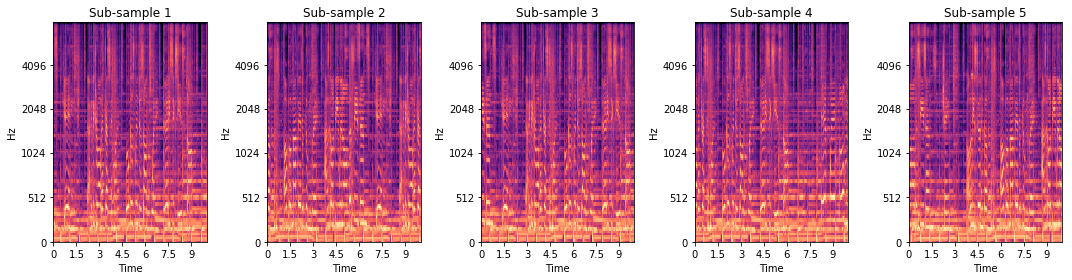

In [207]:
# Select a genre 0-7 
#0 : 'Hip-Hop',
#1 : 'Pop',
#2 : 'Folk',
#3 : 'Experimental',
#4 : 'Rock',
#5 : 'International',
#6 : 'Electronic',
#7 : 'Instrumental'
genre = genre_list[2]
print("Genre: {}".format(genre))

# Define parameters for length of samples in seconds and sample quantity
s_sec=10
s_qty=5

# Setup the figure subplots
fig, ax = plt.subplots(1, s_qty, figsize=(15,4))

# Get random track id of the chosen genre 
tid_name = random.choice(list(tracks[tracks[('track','genre_top')] == genre].index))

# Get the path of the selected audio file
filepath = get_audio_path(audio_dir, tid_name)
print("Sample file: {}".format(filepath))

# Get the time-series and sample rate
y, sr = librosa.load(filepath)

# Calculate the sub-sample time-series length
s_y_len = sr * s_sec

# Setup an empty list for the sub-samples
s_spect_db = []

for i in range(0, s_qty):
    
    # Sub-sample the time-series
    s_y_start = random.randint(0,655081-s_y_len)
    s_y_end = s_y_start + s_y_len
    s_y = y[s_y_start:s_y_end]

    # Generate sub-sample mel spectorgrams and convert dB scale
    s_spect = librosa.feature.melspectrogram(y=s_y, sr=sr, n_fft=2048, hop_length=512)
    s_spect_db.append(librosa.power_to_db(S=s_spect, ref=np.max))
    
# Plot the sub-sample spectrograms
for i in range(0, s_qty):
    ax[i] = plt.subplot(1, s_qty, i+1)
    plot_spect_db(s_spect_db[i], colorbar=False, axes=True)
    plt.title(f'Sub-sample {i+1}')

plt.tight_layout()

print("Shape: {}".format(np.array(s_spect_db).shape))

#### 1.3.2 Setting parameters for randomized sub-sampling <a class="anchor" id="3.2"></a>

V2 edit: 
* added random seed and export to csv file.

In [14]:
# Sample length in seconds
s_sec=10
# Number of samples from each audio file
s_qty=5

In [61]:
# # Generating a dataframe of random seeds
# # Note: This is to be done only once
# random.seed(None)
# df_seed = pd.DataFrame(columns=['seed_value'], data=[random.randint(2,255) for x in range(0,50)], dtype=int)
# df_seed.to_csv('./random_seed.csv', sep=',', index=False)

In [11]:
# Reading in pre-generated seed file
df_seed = pd.read_csv('./random_seed.csv', delimiter=',')

#### 1.3.3 Generation of multiple shorter length spectrograms <a class="anchor" id="3.3"></a>

Functions `generate_subsample_spect_db` and `export_all_subsample_spect_db` were added to [1.1.2](#1.2) and used to generate a subsample of shorter length spectrograms and save them as `.png` files.

In [ ]:
# # Note: This takes a long time to run for the extraction ~ 7 hrs
# export_all_subsample_spect_db(audio_dir, tids[4423:], s_sec=10, s_qty=5)

### 1.4. Generation of Numpy Arrays <a class="anchor" id="4."></a>

#### 1.4.1 Splitting into train, validation, and test sets<a class="anchor" id="4.1"></a>

Applying a Train, Validation, and Test Split of the data utilizing the pre-defined splits as provided in the `fma_metadata`, and generating the track IDs and the genre labels for the 3 sets of data: <br>

* `train_tids`, `train_labels`
* `val_tids`, `val_labels` 
* `test_tids`, `test_lables`

In [16]:
# Split into sets of train, validation, test
train_df = tracks[tracks[('set','split')] == 'training']
val_df = tracks[tracks[('set','split')] == 'validation']
test_df = tracks[tracks[('set','split')] == 'test']

# Getting arrays of track ids for the train, validation, test sets
train_tids = np.array(train_df.index)
val_tids = np.array(val_df.index)
test_tids = np.array(test_df.index)

# Getting arrays of genre labels for the train, validation, test sets
train_labels = np.array(train_df[('track', 'genre_top')])
val_labels = np.array(val_df[('track', 'genre_top')])
test_labels = np.array(test_df[('track', 'genre_top')])

print("No. of samples for train, validation, test are: {}, {}, {}".format(
    len(train_df), len(val_df), len(test_df)))

print("Percentage splits for train, validation, test are: {:.0f}%, {:.0f}%, {:.0f}%".format(
    len(train_df)/len(tracks)*100, len(val_df)/len(tracks)*100, len(test_df)/len(tracks)*100))

No. of samples for train, validation, test are: 6394, 800, 800
Percentage splits for train, validation, test are: 80%, 10%, 10%


#### 1.4.2 Setting parameters for randomized sub-sampling <a class="anchor" id="4.2"></a>

This was defined above in [1.3.2](#3.2), and is placed here for convenience to confirm prior to running the sub-sample extraction to numpy arrays.

In [17]:
# Sample length in seconds
s_sec=10
# Number of samples from each audio file
s_qty=5

#### 1.4.3 Generation of spectrograms and saving as .npy files <a class="anchor" id="4.3"></a>

Functions `export_spect_as_npy`, `export_subsample_spect_as_npy` and `export_subsample_labels_as_npy` were added to [1.1.2](#1.2) and used to generate spectrograms and subsample spectrograms and export them to numpy array `.npy`. <br>

The shape of the output for the exported spectrograms is `(no.samples, spectrogram time-series, spectrogram frequency)`.

In [ ]:
# # This step is skipped as sub-samples would be collected instead
#
# # Note: This takes a long time to run for the extraction ~ ???
# train_spect = export_spect_as_npy(audio_dir, 'train', train_tids)
# val_spect = export_spect_as_npy(audio_dir, 'val', val_tids)
# test_spect = export_spect_as_npy(audio_dir, 'test', test_tids)

In [20]:
# Generation of 5 samples x 10s, without random seed
# Note: This takes a long time to run for the extraction ~ est: 9 hrs
train_spect_sub = export_subsample_spect_as_npy(audio_dir, 'train', train_tids, s_sec, s_qty)
val_spect_sub = export_subsample_spect_as_npy(audio_dir, 'val', val_tids, s_sec, s_qty)
test_spect_sub = export_subsample_spect_as_npy(audio_dir, 'test', test_tids, s_sec, s_qty)

train_labels_sub = export_subsample_labels_as_npy('train', train_labels, s_sec, s_qty)
val_labels_sub = export_subsample_labels_as_npy('val', val_labels, s_sec, s_qty)
test_labels_sub = export_subsample_labels_as_npy('test', test_labels, s_sec, s_qty)


Processing 'train' set audio data to spectrograms and writing output to .npy
Sub-sampling each recording with 5 samples of 10s each.
Processing sample no: 200, time elasped (h:mm:ss): 0:03:57 
Processing sample no: 400, time elasped (h:mm:ss): 0:08:44 
Processing sample no: 600, time elasped (h:mm:ss): 0:14:13 
Processing sample no: 800, time elasped (h:mm:ss): 0:20:36 
Processing sample no: 1000, time elasped (h:mm:ss): 0:27:44 
Processing sample no: 1200, time elasped (h:mm:ss): 0:35:41 
Processing sample no: 1400, time elasped (h:mm:ss): 0:44:25 
Processing sample no: 1600, time elasped (h:mm:ss): 0:53:58 
Processing sample no: 1800, time elasped (h:mm:ss): 1:04:14 
Processing sample no: 2000, time elasped (h:mm:ss): 1:15:21 
Processing sample no: 2200, time elasped (h:mm:ss): 1:27:16 
Processing sample no: 2400, time elasped (h:mm:ss): 1:40:00 
Processing sample no: 2600, time elasped (h:mm:ss): 1:53:30 
Processing sample no: 2800, time elasped (h:mm:ss): 2:07:49 
Processing sampl

#### 1.4.4 Generation of spectrograms with random seeds and saving as .npy files <a class="anchor" id="4.4"></a>

Paramenters for `s_sec` and `s_qty` were previously defined above in [1.3.2](#3.2), and placed here for convenience to confirm prior to running the sub-sample extraction to numpy arrays.

Reading in of `random_seed.csv` file was done above in [1.3.2](#3.2), and is placed here for convenience.

V2 edit:
* reduced subsampling quantity `s_qty` from 5 to 2 samples due to memory limits.<br>

In [17]:
# Sample length in seconds
s_sec=10
# Number of samples from each audio file
s_qty=2
# Setting the set number to be generated, a number between 0 and 49
set_num = 0

# Reading in pre-generated seed file
df_seed = pd.read_csv('./random_seed.csv', delimiter=',')

# Setting the corresponding seed number from df_seed['seed_value']
seed_num = df_seed['seed_value'][set_num]
print("Seed Number: {}".format(seed_num))

Seed Number: 168


In [186]:
# Generation of 1 set of 2 samples x 10s, with random seed
# Note: This takes a long time to run for the extraction ~ est: 5 hrs
train_spect_sub = export_subsample_spect_as_npy(audio_dir, 'train', train_tids, s_sec, s_qty, seed_num)
val_spect_sub = export_subsample_spect_as_npy(audio_dir, 'val', val_tids, s_sec, s_qty, seed_num)
test_spect_sub = export_subsample_spect_as_npy(audio_dir, 'test', test_tids, s_sec, s_qty, seed_num)

train_labels_sub = export_subsample_labels_as_npy('train', train_labels, s_sec, s_qty)
val_labels_sub = export_subsample_labels_as_npy('val', val_labels, s_sec, s_qty)
test_labels_sub = export_subsample_labels_as_npy('test', test_labels, s_sec, s_qty)


Processing 'train' set audio data to spectrograms and writing output to .npy
Sub-sampling each recording with 2 samples of 10s each.
Processing sample no: 200, time elasped (h:mm:ss): 0:03:31 
Processing sample no: 400, time elasped (h:mm:ss): 0:07:27 
Processing sample no: 600, time elasped (h:mm:ss): 0:11:30 
Processing sample no: 800, time elasped (h:mm:ss): 0:15:59 
Processing sample no: 1000, time elasped (h:mm:ss): 0:20:47 
Processing sample no: 1200, time elasped (h:mm:ss): 0:25:55 
Processing sample no: 1400, time elasped (h:mm:ss): 0:31:24 
Processing sample no: 1600, time elasped (h:mm:ss): 0:37:11 
Processing sample no: 1800, time elasped (h:mm:ss): 0:43:14 
Processing sample no: 2000, time elasped (h:mm:ss): 0:49:37 
Processing sample no: 2200, time elasped (h:mm:ss): 0:56:22 
Processing sample no: 2400, time elasped (h:mm:ss): 1:03:26 
Processing sample no: 2600, time elasped (h:mm:ss): 1:10:47 
Processing sample no: 2800, time elasped (h:mm:ss): 1:18:29 
Processing sampl

In [18]:
# Generation of 4 additional sets of 2 samples x 10s, with random seed
# Note: This takes a long time to run for the extraction ~ est: 24 hrs

for set_num in range(1,5):
    # Setting the corresponding seed number from df_seed['seed_value']
    seed_num = df_seed['seed_value'][set_num]
    
    train_spect_sub = export_subsample_spect_as_npy(audio_dir, 'train', train_tids, s_sec, s_qty, seed_num)
    val_spect_sub = export_subsample_spect_as_npy(audio_dir, 'val', val_tids, s_sec, s_qty, seed_num)
    test_spect_sub = export_subsample_spect_as_npy(audio_dir, 'test', test_tids, s_sec, s_qty, seed_num)



Processing 'train' set audio data to spectrograms and writing output to .npy
Sub-sampling each recording with 2 samples of 10s each.
Processing sample no: 200, time elasped (h:mm:ss): 0:03:39 
Processing sample no: 400, time elasped (h:mm:ss): 0:07:35 
Processing sample no: 600, time elasped (h:mm:ss): 0:11:47 
Processing sample no: 800, time elasped (h:mm:ss): 0:16:25 
Processing sample no: 1000, time elasped (h:mm:ss): 0:21:25 
Processing sample no: 1200, time elasped (h:mm:ss): 0:26:45 
Processing sample no: 1400, time elasped (h:mm:ss): 0:32:22 
Processing sample no: 1600, time elasped (h:mm:ss): 0:38:39 
Processing sample no: 1800, time elasped (h:mm:ss): 0:45:16 
Processing sample no: 2000, time elasped (h:mm:ss): 0:52:09 
Processing sample no: 2200, time elasped (h:mm:ss): 0:59:44 
Processing sample no: 2400, time elasped (h:mm:ss): 1:07:48 
Processing sample no: 2600, time elasped (h:mm:ss): 1:15:49 
Processing sample no: 2800, time elasped (h:mm:ss): 1:23:47 
Processing sampl

### 1.5. Generation of Single Sample Set for Embeddings <a class="anchor" id="5."></a>

#### 1.5.1 Generation of full set of 10s .npy files for embedding set <a class="anchor" id="5.1"></a>

A single sample of 10s for each file is taken with the last indexed random seed.  This set of spectrograms shall be used for generation of the song embeddings based on a trained genre classification model.

In [17]:
# Sample length in seconds
s_sec=10
# Number of samples from each audio file
s_qty=1
# Setting the set number to be generated, a number between 0 and 49
set_num = 49

# Reading in pre-generated seed file
df_seed = pd.read_csv('./random_seed.csv', delimiter=',')

# Setting the corresponding seed number from df_seed['seed_value']
seed_num = df_seed['seed_value'][set_num]
print("Seed Number: {}".format(seed_num))

# Generation of 1 set of 1 samples x 10s, with the last random seed (index=49)
# Note: This takes a long time to run for the extraction ~ est: 5 hrs
train_spect_sub = export_subsample_spect_as_npy(audio_dir, 'train', train_tids, s_sec, s_qty, seed_num)
val_spect_sub = export_subsample_spect_as_npy(audio_dir, 'val', val_tids, s_sec, s_qty, seed_num)
test_spect_sub = export_subsample_spect_as_npy(audio_dir, 'test', test_tids, s_sec, s_qty, seed_num)

train_labels_sub = export_subsample_labels_as_npy('train', train_labels, s_sec, s_qty)
val_labels_sub = export_subsample_labels_as_npy('val', val_labels, s_sec, s_qty)
test_labels_sub = export_subsample_labels_as_npy('test', test_labels, s_sec, s_qty)

Seed Number: 116

Processing 'train' set audio data to spectrograms and writing output to .npy
Sub-sampling each recording with 1 samples of 10s each.
Processing sample no: 200, time elasped (h:mm:ss): 0:03:21 
Processing sample no: 400, time elasped (h:mm:ss): 0:06:51 
Processing sample no: 600, time elasped (h:mm:ss): 0:10:25 
Processing sample no: 800, time elasped (h:mm:ss): 0:14:21 
Processing sample no: 1000, time elasped (h:mm:ss): 0:18:32 
Processing sample no: 1200, time elasped (h:mm:ss): 0:22:52 
Processing sample no: 1400, time elasped (h:mm:ss): 0:27:21 
Processing sample no: 1600, time elasped (h:mm:ss): 0:32:20 
Processing sample no: 1800, time elasped (h:mm:ss): 0:37:14 
Processing sample no: 2000, time elasped (h:mm:ss): 0:42:21 
Processing sample no: 2200, time elasped (h:mm:ss): 0:47:39 
Processing sample no: 2400, time elasped (h:mm:ss): 0:53:07 
Processing sample no: 2600, time elasped (h:mm:ss): 0:58:45 
Processing sample no: 2800, time elasped (h:mm:ss): 1:04:24 